### Quantify density, alignment of collagen fibers

**Author:** Dhananjay Bhaskar

In [1]:
import pickle
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import skimage.io as io
import scipy.ndimage as ndi
from scipy.interpolate import interp1d

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
matplotlib.rcParams.update({'font.size':20})

- **_hist.csv :** List of bin values and numbers of observations in each bin. Bin values correspond to relative angle if boundaries are used, and absolute angle if no boundary is used
- **_values.csv :** relative angles
- **_stats.csv :** Statistics of the relative angles
- **_fibFeatNames.csv :** Names of the 34 features
- **_fibFeatures.csv :** 34 features in 34 columns

In [2]:
cFEATNAMES = '0034_cropped_fibFeatNames.csv'
cFIBFEATS = '0034_cropped_fibFeatures.csv'
cHIST = '0034_cropped_hist.csv'
cSTATS = '0034_cropped_stats.csv'
cVALS = '0034_cropped_values.csv'

df_cFEATNAMES = pd.read_csv(cFEATNAMES, header=None)
df_cFIBFEATS = pd.read_csv(cFIBFEATS, header=None)
df_cHIST = pd.read_csv(cHIST, header=None)
df_cSTATS = pd.read_csv(cSTATS, header=None)
df_cVALS = pd.read_csv(cVALS, header=None)

In [3]:
for stat in df_cSTATS[0]:
    print stat

        Mean	  144.29
      Median	  144.46
    Variance	   0.84
     Std Dev	   1.30
Coef of Alignment	   0.16
    Skewness	   0.00
    Kurtosis	  -0.01
   Omni Test	   0.00
  red pixels	  293.00
yellow pixels	  14970.00
green pixels	  171325.00
total pixels	  640000.00


#### Plot angular distribution of segmented fiber fragments

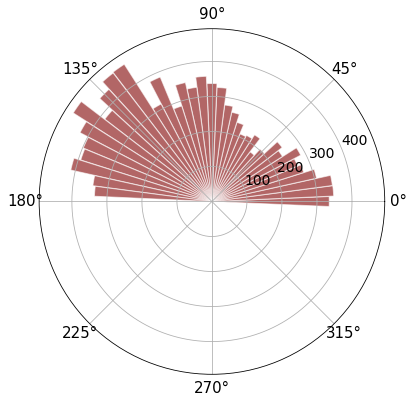

In [4]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

N = len(df_cHIST)
theta = np.arange(0.0, np.pi, np.pi/N)
radii = df_cHIST[1]
width = [np.pi/37] * N
bars = ax.bar(theta, radii, width=width, bottom=0.0, edgecolor='white')
for r,bar in zip(radii, bars):
    bar.set_facecolor(cm.jet(r/10.0))
    bar.set_alpha(0.6)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=14)
plt.show()
# plt.savefig('angle_dist.png', transparent=True)

Text(0,0.5,u'Frequency')

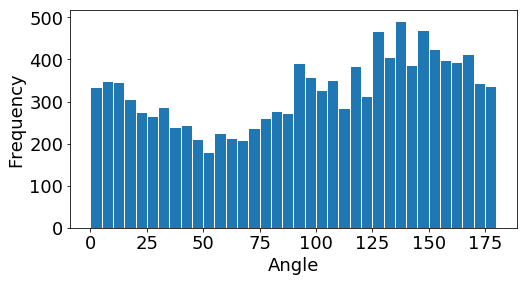

In [5]:
plt.figure(figsize=(8,4))
plt.hist(list(df_cVALS[0]), bins=36, edgecolor='white')
plt.xlabel("Angle", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

In [6]:
headings = list()
for f_name in list(df_cFEATNAMES[0]):
    feat = f_name.split(":")[1]
    feat = feat.lstrip()
    feat = feat.rstrip()
    headings.append(feat)
df_cFIBFEATS.columns = headings

In [7]:
df_cFIBFEATS.head()

,fiber Key into CTFIRE list,end point row,end point col,fiber abs ang,fiber weight,total length,end to end length,curvature,width,dist to nearest 2,...,box alignment 32,box alignment 64,box alignment 128,nearest dist to bound,inside epi region,nearest relative boundary angle,extension point distance,extension point angle,boundary point row,boundary point col
0,1,78,1,28.666,0,140.78,118.27,0.84011,4.6819,5.1569,...,0.70651,0.27001,0.042572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,76,4,32.969,0,140.78,118.27,0.84011,4.6819,3.3839,...,0.43259,0.24975,0.042055,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,75,7,38.832,0,140.78,118.27,0.84011,4.6819,3.3839,...,0.40143,0.24707,0.053379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,73,10,46.145,0,140.78,118.27,0.84011,4.6819,3.6056,...,0.31901,0.25240,0.060586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,71,13,35.856,0,140.78,118.27,0.84011,4.6819,3.9241,...,0.32044,0.28163,0.069651,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_cFIBFEATS.columns

Index([u'fiber Key into CTFIRE list', u'end point row', u'end point col',
       u'fiber abs ang', u'fiber weight', u'total length',
       u'end to end length', u'curvature', u'width', u'dist to nearest 2',
       u'dist to nearest 4', u'dist to nearest 8', u'dist to nearest 16',
       u'mean nearest dist', u'std nearest dist', u'box density 32',
       u'box density 64', u'box density 128', u'alignment of nearest 2',
       u'alignment of nearest 4', u'alignment of nearest 8',
       u'alignment of nearest 16', u'mean nearest align', u'std nearest align',
       u'box alignment 32', u'box alignment 64', u'box alignment 128',
       u'nearest dist to bound', u'inside epi region',
       u'nearest relative boundary angle', u'extension point distance',
       u'extension point angle', u'boundary point row', u'boundary point col'],
      dtype='object')

#### Plot segmented fibers

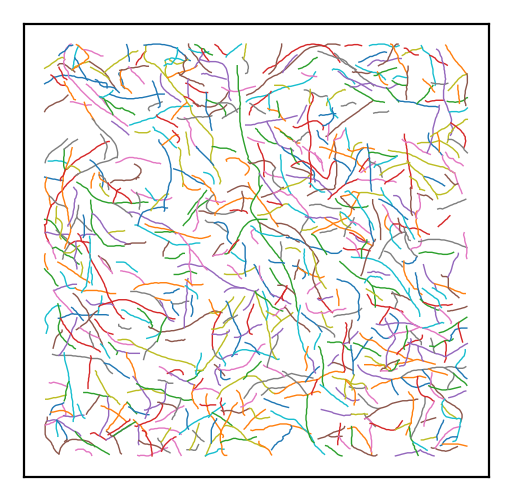

In [9]:
fibIDs = np.unique(df_cFIBFEATS['fiber Key into CTFIRE list'])
numfibs = len(fibIDs)

plt.figure(figsize=(3,3), dpi=200)
for fid in fibIDs:
    
    fib = df_cFIBFEATS[df_cFIBFEATS['fiber Key into CTFIRE list'] == fid]
    fib_angle = df_cVALS[df_cFIBFEATS['fiber Key into CTFIRE list'] == fid]
    plt.plot(fib['end point col'], fib['end point row'], '-', linewidth=0.5)

plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
# plt.savefig('segmented_fibers_red.png', transparent=True)
plt.show()

#### Compute fiber statistics

In [10]:
fibIDs = np.unique(df_cFIBFEATS['fiber Key into CTFIRE list'])
numfibs = len(fibIDs)

fib_len = list()
fib_cur = list()
fib_wid = list() 

for fid in fibIDs:
    
    df_subset = df_cFIBFEATS[df_cFIBFEATS['fiber Key into CTFIRE list']==fid]
    flen = np.unique(df_subset['total length'].tolist())
    fcur = np.unique(df_subset['curvature'].tolist())
    fwid = np.unique(df_subset['width'].tolist())
    
    if (len(flen) != 1 or len(fwid) != 1 or len(fcur) != 1):
        print 'ERROR: Fiber ID: ' + repr(fid)
    
    fib_len.append(flen[0])
    fib_cur.append(fcur[0])
    fib_wid.append(fwid[0])

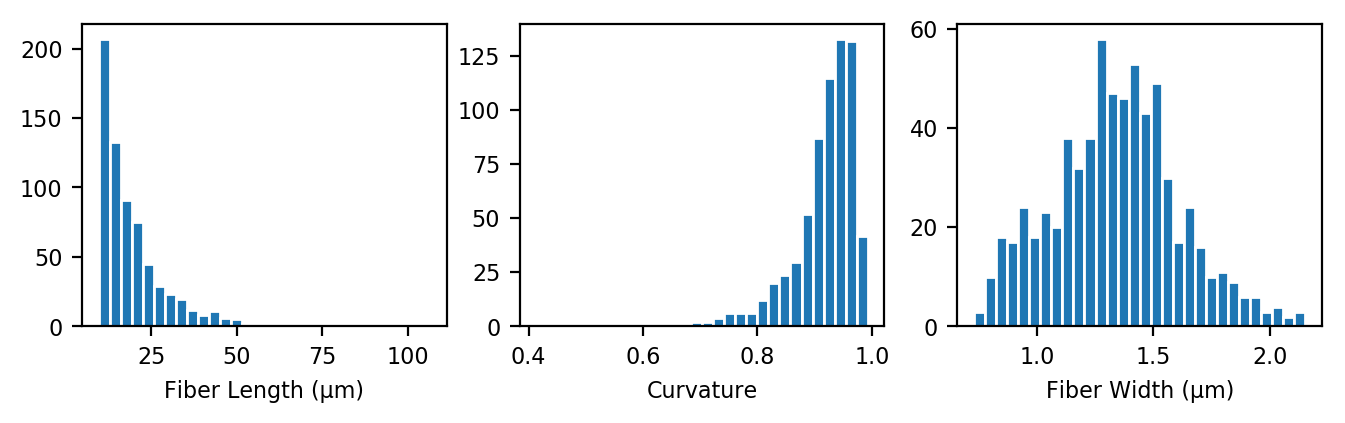

In [11]:
px2um = 0.318

plt.figure(figsize=(8,2), dpi=200)
plt.rcParams.update({'font.size': 2})

ax1 = plt.subplot(131)
ax1.hist(np.multiply(fib_len, px2um), bins=30, edgecolor='white');
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.set_xlabel(u'Fiber Length (μm)', fontsize=8)

ax2 = plt.subplot(132)
ax2.hist(fib_cur, bins=30, edgecolor='white');
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.set_xlabel('Curvature', fontsize=8)

ax3 = plt.subplot(133)
ax3.hist(np.multiply(fib_wid, px2um), bins=30, edgecolor='white');
ax3.tick_params(axis='x', labelsize=8)
ax3.tick_params(axis='y', labelsize=8)
ax3.set_xlabel(u'Fiber Width (μm)', fontsize=8)

plt.show()

#### Save histogram data

In [12]:
fib_len_um = np.multiply(fib_len, px2um)
fib_wid_um = np.multiply(fib_wid, px2um)

with open("0034_fib_stats.pickle", "wb") as f:
    pickle.dump((fib_len_um,fib_wid_um), f)

#### Local fiber density

In [13]:
density = np.zeros([800,800])

for index, row in df_cFIBFEATS.iterrows():
    density[int(row['end point col'])-1,int(row['end point row'])-1] = row['box density 64']

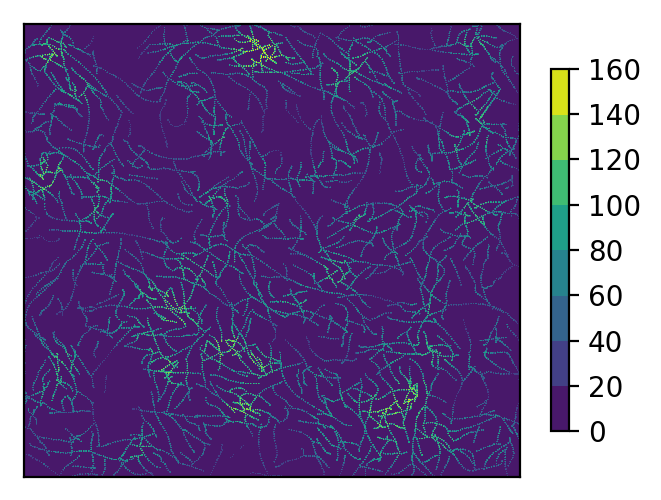

In [14]:
plt.figure(figsize=(4,3), dpi=200)
plt.contourf(density)
cbar = plt.colorbar(extend='neither', spacing='proportional', orientation='vertical', shrink=0.8)
cbar.ax.tick_params(labelsize=10) 
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.show()
# plt.savefig('local_density.png', transparent=True)

#### Local fiber alignment

In [15]:
alignment = np.zeros([800,800])

for index, row in df_cFIBFEATS.iterrows():
    alignment[int(row['end point col'])-1,int(row['end point row'])-1] = row['box alignment 128']

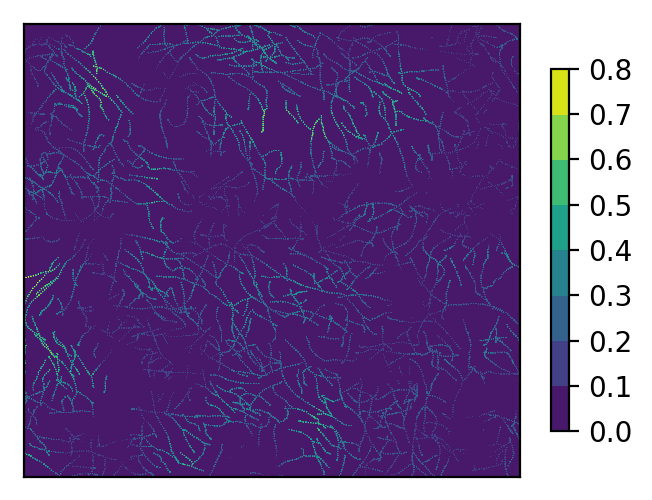

In [16]:
plt.figure(figsize=(4,3), dpi=200)
plt.contourf(alignment)
cbar = plt.colorbar(extend='neither', spacing='proportional', orientation='vertical', shrink=0.8)
cbar.ax.tick_params(labelsize=10) 
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.show()
# plt.savefig('local_alignment.png', transparent=True)

#### Sub-divide image into patches

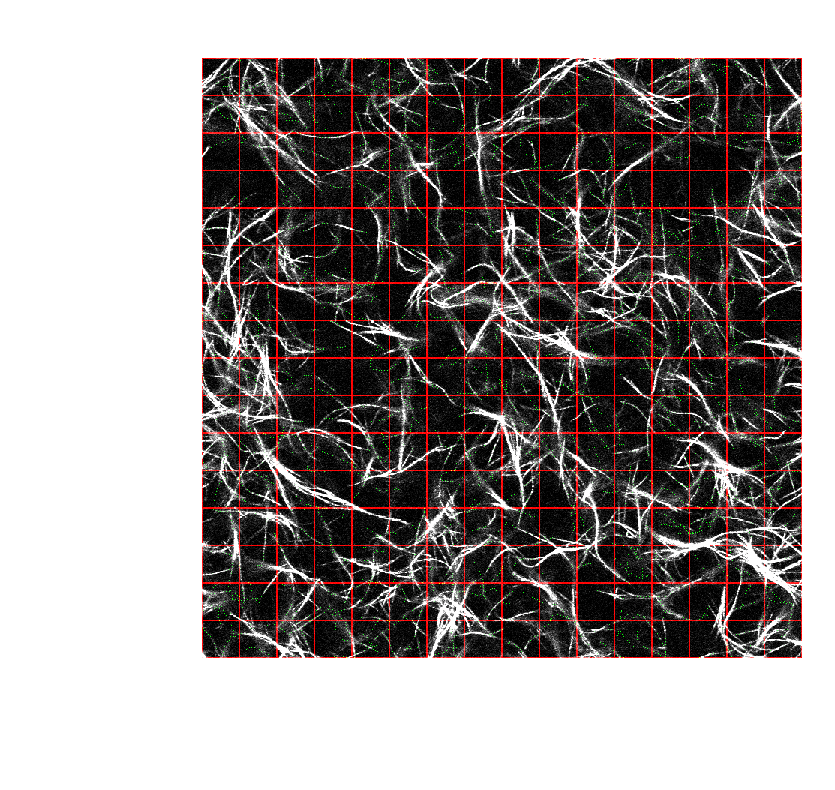

In [17]:
boxsize = 50

cropped_img = io.imread("0034_thresh_cropped.jpg")
(nrows, ncols, nchannels) = np.shape(cropped_img)

for i in range(1,nrows+1):
    if (i % boxsize == 0) or (i == 1):
        cropped_img[i-1:i+1,:,0] = 255
        cropped_img[:,i-1:i+1,0] = 255
        
for index, row in df_cFIBFEATS.iterrows():
    rval = int(row['end point row'])-1
    cval = int(row['end point col'])-1
    cropped_img[rval,cval,1] = 255

plt.figure(figsize=(4,4), dpi=300)
plt.subplots_adjust(left=0, right=0.5, top=0.5, bottom=0)
plt.axis("off")
plt.imshow(cropped_img)
plt.show()

#### Calculate fiber density per unit area

In [18]:
patch_area_um = (boxsize**2) * (px2um**2)

box_fib_dict = dict()
for i in range(nrows/boxsize):
     for j in range(ncols/boxsize):
            box_fib_dict[(i,j)] = set()
            
for index, row in df_cFIBFEATS.iterrows():
    rval = int(row['end point row'])-1
    cval = int(row['end point col'])-1
    fid = int(row['fiber Key into CTFIRE list'])
    i_ind = rval/boxsize
    j_ind = cval/boxsize 
    box_fib_dict[(i_ind,j_ind)].add(fid)
    
num_fibs = list()
for key in box_fib_dict.keys():
    num_fibs.append(len(box_fib_dict[key]))
    
print "Mean number of fibers per box: " + repr(np.mean(num_fibs))
print "Std Dev. " + repr(np.std(num_fibs))
print "Number of fibers per unit area: " + repr(np.mean(num_fibs)/patch_area_um)

Mean number of fibers per box: 6.36328125
Std Dev. 2.2423610287815916
Number of fibers per unit area: 0.025170211819152723


In [19]:
with open("0034_fibcount_boxsize_50.pickle", "wb") as f:
    pickle.dump(num_fibs, f)

#### Scaling for mesh size

In [20]:
sqrt_patch_area_list = list()
avg_num_fibers_list = list()

for boxsize in [5,10,20,40,50,80,100,160,200,400,800]:
    
    patch_area_um = (boxsize**2) * (px2um**2)
    
    box_fib_dict = dict()
    for i in range(nrows/boxsize):
         for j in range(ncols/boxsize):
                box_fib_dict[(i,j)] = set()

    for index, row in df_cFIBFEATS.iterrows():
        rval = int(row['end point row'])-1
        cval = int(row['end point col'])-1
        fid = int(row['fiber Key into CTFIRE list'])
        i_ind = rval/boxsize
        j_ind = cval/boxsize 
        box_fib_dict[(i_ind,j_ind)].add(fid)

    num_fibs = list()
    for key in box_fib_dict.keys():
        num_fibs.append(len(box_fib_dict[key]))
    
    sqrt_patch_area_list.append(np.sqrt(patch_area_um))
    avg_num_fibers_list.append(np.mean(num_fibs))

In [21]:
print u"Number of fibers, Area (μm^2)"
boxcount_res = zip(avg_num_fibers_list, np.power(sqrt_patch_area_list,2))
boxcount_res

Number of fibers, Area (μm^2)


[(0.3504296875, 2.5281000000000002),
 (0.82515625, 10.112400000000001),
 (1.916875, 40.449600000000004),
 (4.74, 161.79840000000002),
 (6.36328125, 252.81),
 (12.29, 647.1936000000001),
 (17.4375, 1011.24),
 (36.68, 2588.7744000000002),
 (54.375, 4044.96),
 (184.75, 16179.84),
 (678.0, 64719.36)]

#### Interpolate and calculate area per fiber

In [22]:
f = interp1d(avg_num_fibers_list, np.power(sqrt_patch_area_list,2), kind='cubic')

In [23]:
xs = np.linspace(np.min(avg_num_fibers_list), np.max(avg_num_fibers_list), num=10000, endpoint=True)
ys = f(xs)

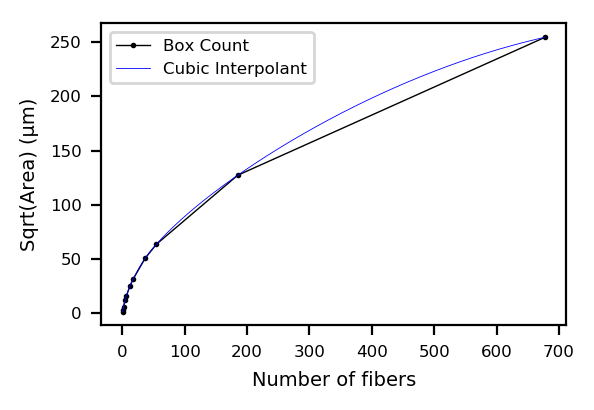

In [24]:
plt.figure(figsize=(3,2), dpi=200)
plt.plot(avg_num_fibers_list, sqrt_patch_area_list, 'ko-', linewidth=0.5, markersize=1, label="Box Count")
plt.plot(xs, np.sqrt(ys), 'b-', linewidth=0.3, label="Cubic Interpolant")
plt.xlabel("Number of fibers", fontsize=7)
plt.ylabel(u"Sqrt(Area) (μm)", fontsize=7)
plt.tick_params(axis='x', labelsize=6)
plt.tick_params(axis='y', labelsize=6)
plt.legend(prop={'size': 6})

In [25]:
area_per_fiber = f(1.0)
print u"Area per fiber (μm^2): " + np.array_str(area_per_fiber)
print "Total number of segmented fibers: " + repr(numfibs)

Area per fiber (μm^2): 13.917344418545861
Total number of segmented fibers: 678


#### Save number of segmented fibers and mesh size

In [26]:
with open("0034_boxcount.pickle", "wb") as f:
    pickle.dump((boxcount_res, area_per_fiber, numfibs), f)

In [27]:
print "Total area of the image: " + repr(800*800*px2um*px2um) + u" μm^2"

Total area of the image: 64719.36 μm^2


#### Quantify fiber density by thresholding image

In [28]:
cropped_img = io.imread("0034_cropped.tif")
(nrows, ncols) = np.shape(cropped_img)

([], <a list of 0 Text yticklabel objects>)

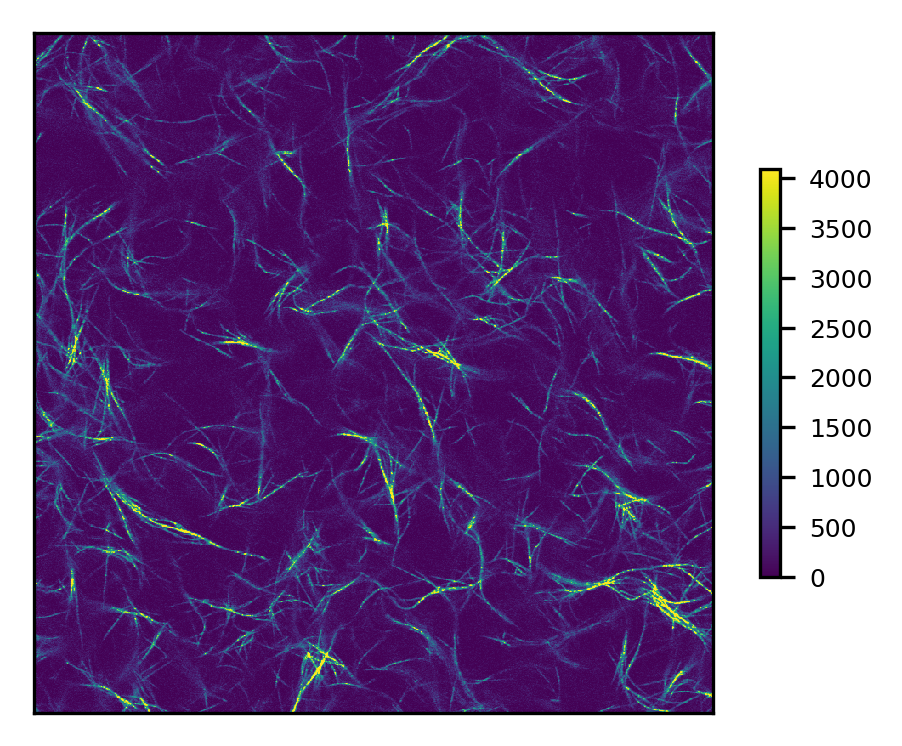

In [29]:
plt.figure(figsize=(4,3), dpi=300)
plt.imshow(cropped_img)
cbar = plt.colorbar(extend='neither', spacing='proportional', orientation='vertical', shrink=0.6)
cbar.ax.tick_params(labelsize=6)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

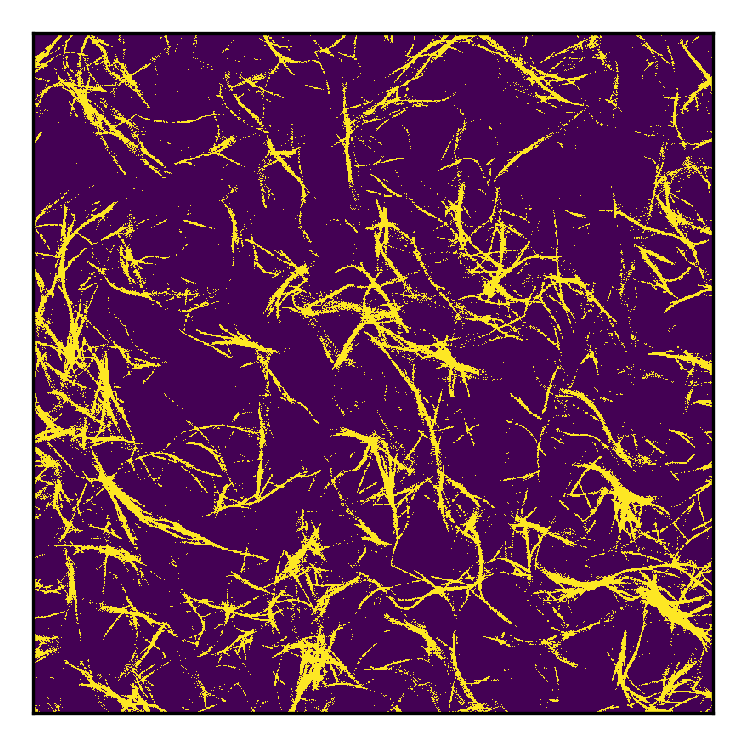

In [30]:
plt.figure(figsize=(3,3), dpi=300)
plt.imshow(cropped_img>500)
plt.xticks([])
plt.yticks([])

In [31]:
sqrt_patch_area_list = list()
avg_thresh_list = list()
box_sizes = [5,10,20,40,50,80,100,160,200,400,800]
box_50_prop = None

for boxsize in box_sizes:
    
    patch_area_um = (boxsize**2) * (px2um**2)
    
    box_fib_dict = dict()
    for i in range(nrows/boxsize):
         for j in range(ncols/boxsize):
                box_fib_dict[(i,j)] = 0

    for rval in range(nrows):
        for cval in range(ncols):
            i_ind = rval/boxsize
            j_ind = cval/boxsize 
            if cropped_img[rval,cval] > 500:
                box_fib_dict[(i_ind,j_ind)] = box_fib_dict[(i_ind,j_ind)] + 1

    num_pxs = list()
    for key in box_fib_dict.keys():
        num_pxs.append(box_fib_dict[key])
       
    # store proportion of pixels above threshold in each box for box size 50
    if boxsize == 50:
        box_50_prop = np.true_divide(num_pxs,boxsize**2)
    
    sqrt_patch_area_list.append(np.sqrt(patch_area_um))
    
    # store mean value (over all boxes) of number of pixels above threshold 
    avg_thresh_list.append(np.mean(num_pxs))

In [32]:
print u"Proportion of foreground pixels, Area (μm^2)"
boxcount_res = zip(avg_thresh_list, np.power(sqrt_patch_area_list,2))
boxcount_res

Proportion of foreground pixels, Area (μm^2)


[(3.658359375, 2.5281000000000002),
 (14.6334375, 10.112400000000001),
 (58.53375, 40.449600000000004),
 (234.135, 161.79840000000002),
 (365.8359375, 252.81),
 (936.54, 647.1936000000001),
 (1463.34375, 1011.24),
 (3746.16, 2588.7744000000002),
 (5853.375, 4044.96),
 (23413.5, 16179.84),
 (93654.0, 64719.36)]

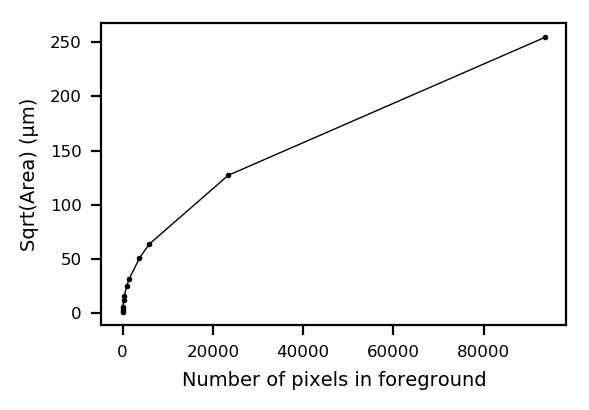

In [33]:
plt.figure(figsize=(3,2), dpi=200)
plt.plot(avg_thresh_list, sqrt_patch_area_list, 'ko-', linewidth=0.5, markersize=1)
plt.xlabel("Number of pixels in foreground", fontsize=7)
plt.ylabel(u"Sqrt(Area) (μm)", fontsize=7)
plt.tick_params(axis='x', labelsize=6)
plt.tick_params(axis='y', labelsize=6)

In [34]:
with open("0034_imgcount.pickle", "wb") as f:
    pickle.dump((box_sizes, avg_thresh_list, box_50_prop), f)

([], <a list of 0 Text yticklabel objects>)

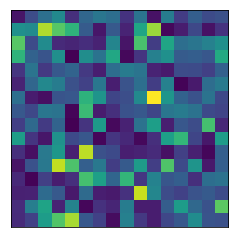

In [35]:
plt.imshow(box_50_prop.reshape(16,16))
plt.xticks([])
plt.yticks([])